In [1]:
#import important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
#set width of column
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 999
#suppress warning
import warnings
warnings.filterwarnings("ignore")
#translation api
from googletrans import Translator
import math

In [42]:
#Read CSV
#test using 20_24
file = '2017_12_13_15_20.csv'
user= pd.read_csv(file).sample(10000)
## drop unuseful columns
user=user.drop(['device_type','product_name','event_id','device_id','device_hw_form'],axis=1)
## drop row whose info is almost lost
user=user[user['device_hw_ram'].notnull()]
user.head()

,device_hw_proc,device_hw_ram,device_hw_display,device_hw_video,device_os_name,device_os_version
116092,Intel64 Family 6 Model 158 Stepping 9 Intel(R) Core(TM) i3-7100 CPU @ 3.90GHz,8GB 1073741824,"1600x900 96,96 32","Intel(R) HD Graphics 630, PCI\VEN_8086&DEV_5912&SUBSYS_82A2103C&REV_04\3&11583659&0&10",Microsoft Windows 10 Enterprise,10.0.15063 Build 15063
367991,Intel64 Family 6 Model 60 Stepping 3 Intel(R) Core(TM) i7-4770K CPU @ 3.50GHz,16GB 2147483648,"1920x1080 96,96 32, 1920x1080 96,96 32","AMD Radeon HD 7800 Series, PCI\VEN_1002&DEV_6818&SUBSYS_04321043&REV_00\4&3834D97&0&0008, \\.\DISPLAY1",Microsoft Windows 8.1 Pro,6.3.9600 Build 9600
452075,"AMD64 Family 21 Model 48 Stepping 1 AMD A8-7600 Radeon R7, 10 Compute Cores 4C+6G",7GB 2147483648,"3840x2160 144,144 32","NVIDIA GeForce GTX 950, PCI\VEN_10DE&DEV_1402&SUBSYS_29513842&REV_A1\4&16F08CE9&0&0011",Microsoft Windows 10 Pro,10.0.14393 Build 14393
406667,Intel64 Family 6 Model 42 Stepping 7 Intel(R) Core(TM) i5-2430M CPU @ 2.40GHz,4GB 1885263872,"1366x768 96,96 32","Intel(R) HD Graphics 3000, PCI\VEN_8086&DEV_0116&SUBSYS_908B104D&REV_09\3&11583659&0&10",Microsoft Windows 10 Home,10.0.14393 Build 14393
371406,Intel64 Family 6 Model 60 Stepping 3 Intel(R) Core(TM) i5-4200M CPU @ 2.50GHz,4GB 1791541248,"1366x768 96,96 32","Intel(R) HD Graphics 4600, PCI\VEN_8086&DEV_0416&SUBSYS_502417AA&REV_06\3&11583659&2&10",Microsoft Windows 7 Professional,6.1.7601 Service Pack 1 Build 7601


In [3]:
def deleteStepping(s,brand,stepping):
    length=len(stepping)-1
    
    start = s[s.find(brand)+length:].find(brand)+length
    
    return s[start:]

def splitC(s):
    ##make data consistent#
    s=" ".join(s.split())
    
    if 'Pentium(R)' in s and 'Intel(R) Pentium(R)' not in s:
        s= s.replace('Pentium(R)','Intel(R) Pentium(R)')
    elif 'Celeron(R)' in s and 'Intel(R) Celeron(R)' not in s:
        s= s.replace('Celeron(R)','Intel(R) Celeron(R)')
    elif 'Intel(R)' in s and 'Core(TM)' not in s and 'Core' in s and '-Core' not in s:
        s= s.replace('Core','Core(TM)')
    elif 'AMD64' in s and 'Quad-Core' in s:
        s=s.replace('Quad-Core','AMD Quad-Core')
    elif 'Quad-Core' in s and 'Processor' in s:
        s=s.replace('Quad-Core','AMD Quad-Core')
    else:
        s=s

        
    if 'AMD' in s and 'RADEON' in s:
        s= s.replace('RADEON','Radeon') 
    if 'AMD' in s and " APU with AMD " in s:
        s=s.replace(" with AMD "," ")
    if 'AMD' in s and " APU " in s:
        s=s.replace(" APU "," ")
    if 'AMD' in s and " with " in s:
        s=s.replace(" with "," ")
    if 'AMD' in s and " Graphics" in s:
        s=s.replace("Graphics","")
    if 'AMD' in s and "Radeon(TM)" in s:
        s=s.replace("Radeon(TM)","Radeon")
    if "Radeon(tm)" in s:
        s=s.replace("Radeon(tm)","Radeon")
    
    if 'i3 ' in s and 'i3-' not in s:
        s=s.replace('i3 ','i3-')
    elif 'i5 ' in s and 'i5-' not in s:
        s=s.replace('i5 ','i5-')
    elif 'i7 ' in s and 'i7-' not in s:
        s=s.replace('i7 ','i7-')
    else:
        s=s
        
    ###extract with comma
    if ',' in s:
        first=s.split(',')[0]
        second=s.split(',')[1].lstrip()
        if 'Intel64' in first and 'Intel64' in second:
            firstN = deleteStepping(first,'Intel','Intel64')
            secondN=deleteStepping(second,'Intel','Intel64')
            return (firstN,secondN)      
        elif 'Intel' in first and 'Intel' in second:
            start1 = first.find('Intel')
            start2 = second.find('Intel')
            return (first[start1:],second[start2:])
        elif 'AMD' in first  and ('CORES' in second.upper() or '+' in second):
            if 'AMD64' in first:
                return deleteStepping(first,'AMD','AMD64')
            else:
                start = first.find('AMD')
                s= first[start:]
                return s
        elif 'AMD64' in first and 'AMD64' in second:
            firstN = deleteStepping(first,'AMD','AMD64')
            secondN = deleteStepping(second,'AMD','AMD64')
            return (firstN,secondN)
        elif 'AMD' in second and 'AMD' in first:
            start1 = first.find('AMD')
            start2 = second.find('AMD')
            return (first[start1:],second[start2:])
        elif 'AMD' not in s and 'Intel' not in s:
            return 'Unusual'
        else:
            return 'Unusual'
    else:
        if 'Intel' in s and 'Intel64' in s:
            start = s[s.find('Intel64')+6:].find('Intel')+6
        elif 'Intel' in s and 'Genuine' in s:
            start = s.find('Genuine')
        elif 'Intel' in s:
            start = s.find('Intel')       
                    
        elif 'AMD64' in s:
            if 'AMD ' in s:
                start =s[s.find('AMD64')+4:].find('AMD')+4
            else:
                start=s.find('AMD64')
        elif ('x64' in s  or 'x86' in s) and 'AMD' in s:
            start =s.find('AMD')
        else:
            start=0
            
    s=" ".join(s.split())
       
    return s[start:]

def splitB(s):
    if len(s)!=2:
        if 'Intel' in s:
            if 'CPU' in s:
                s=s.replace('CPU',' ')
            if '@' in s:
                end = s.find('@')
            elif '-' in s:
                end = s.find('-')+5
            else:
                end=len(s)+1

            if 'Genuine' in s:
                start = s.find('Genuine')
            elif 'Intel(R)' in s:
                start = s.find('Intel(R)')+8
            else:
                start=0
            sn=s[start:end]
        else:
            sn=s
    else:
        return s
    
    ##correct Core(TM)2 E series
    if 'Core(TM)2' in s and 'Core(TM)2 Duo' not in s and 'Quad' not in s:
        sn=sn.replace('Core(TM)2','Core(TM)2 Duo')
    elif 'Core(TM) Duo' in s and 'Core(TM)2 Duo' not in s:
        sn=sn.replace('Core(TM) Duo','Core(TM)2 Duo')
    else:
        sn=sn
    sn=" ".join(sn.split()) 
    ###correct E series
    series = [' 4300',' 4400',' 6300',' 6320',' 6400',' 6420',' 6600',' 6700']


    if 'Core(TM)2 Duo'in sn:
        for sery in series:
            if 'Core(TM)2 Duo'+sery in sn:
                sn=sn.replace(sery,' E'+sery.lstrip())
                break
    return sn    

def getC(df,threshold):
    df=(100*df.brand.value_counts()/len(df.brand)).sort_values()
    listR=df[df.cumsum()>threshold].index
    return listR

###filter the RAM you want. Otherwise, it will be treated as "Rare". Criteria is the cumulative proportion.
def filterC(s,listC):
    if s in listC:
        return s
    else:
        return 'Rare'
    

def consis(s):
    if 'Intel' in s and 'Intel(R)' not in s:
        s=s.replace('Intel','Intel(R)')
    if 'Intel(R)' in s and 'Intel(R) -' in s:
        s=s.replace('Intel(R) -','Intel(R)')
    if 'Intel(R)' in s and 'Family ' in s:
        s=s.replace('Family ','Family')
    if 'Intel' in s and '(PE) ' in s:
        s=s.replace('(PE) ','')
    if 'Intel' in s and '(PE64) ' in s:
        s=s.replace('(PE64) ','')
    
    if 'Radeon(TM)' in s:
        s=s.replace('Radeon(TM)','Radeon')
    if 'Radeon (TM)' in s:
        s=s.replace('Radeon (TM)','Radeon')
    if 'RADEON' in s:
        s=s.replace('RADEON','Radeon')
    if 'Radeon.' in s:
        s=s.replace('Radeon.','Radeon')
    if 'RadeonT' in s:
        s=s.replace('RadeonT','Radeon')
    
    if 'Radeon' in s and 'AMD' not in s and 'ATI' not in s:
        s=s.replace('Radeon','AMD(ATI) Radeon')
    if 'ASUS' in s and 'Radeon' in s:
        s=s.replace('ASUS','')
    if 'Intel' in s and 'Iris' in s and 'Iris(TM)' not in s:
        s=s.replace('Iris','Iris(TM)')
    if 'Intel' in s and 'Iris(R)' in s:
        s=s.replce('Iris(R)','Iris(TM)')
    if 'ATI' in s and 'AMD' not in s:
        s=s.replace('ATI','AMD(ATI)')
    if 'AMD' in s and 'ATI' not in s:
        s=s.replace('AMD','AMD(ATI)')
    
    # delete redundant info
    if 'AMD' in s or 'Intel(R)' in s or 'NVIDIA' in s:
        if '(Microsoft Corporation - WDDM 1.0)' in s:
            s=s.replace('(Microsoft Corporation - WDDM 1.0)','')
        elif '(Microsoft Corporation - WDDM 1.1)' in s:
            s=s.replace('(Microsoft Corporation - WDDM 1.1)','') 
        elif '(Microsoft Corporation - WDDM 1.2)' in s:
            s=s.replace('(Microsoft Corporation - WDDM 1.2)','')
        elif '(Microsoft Corporation — WDDM 1.2)' in s:
            s=s.replace('(Microsoft Corporation — WDDM 1.2)','')
        elif '(Microsoft Corporation — WDDM 1.2)' in s:
            s=s.replace('(Microsoft Corporation — WDDM 1.2)','')
        elif '(Microsoft Corporation - WDDM v1.1)' in s:
            s=s.replace(' (Microsoft Corporation - WDDM v1.1)','')
        elif '(Microsoft Corporation WDDM 1.1)' in s:
            s=s.replace('(Microsoft Corporation WDDM 1.1)','')
        elif '(Microsoft Corporation - WDDM v1.20)' in s:
            s=s.replace('(Microsoft Corporation - WDDM v1.20)','')
        elif '(Microsoft Corporation - WDDM v1.2)' in s:
            s=s.replace('(Microsoft Corporation - WDDM v1.2)','')
        elif '(Engineering Sample - WDDM v1.1)' in s:
            s=s.replace('(Engineering Sample - WDDM v1.1)','')
        elif '(Microsoft Corporation - WDDM)' in s:
            s=s.replace('(Microsoft Corporation - WDDM)','')
        elif '(Microsoft Corporation- WDDM v1.20)' in s:
            s=s.replace('(Microsoft Corporation- WDDM v1.20)','')
        elif '(Bootcamp XG edition by bootcampdrivers.com)' in s:
            s=s.replace('(Bootcamp XG edition by bootcampdrivers.com)','')
        elif '(Engineering Sample - WDDM v1.20)' in s:
            s=s.replace('(Engineering Sample - WDDM v1.20)','')
        else:
            s=s
    # Clean ASUS
    if 'ASUS' in s:
        if 'EAH' in s:
            s=s.replace('ASUS ','AMD(ATI) Radeon ').replace('EAH', 'HD ').replace(' Series','') 
        elif 'HD' in s:
            s=s.replace('ASUS ','AMD(ATI) Radeon ').replace('HD','HD ').replace(' Series','')
        elif 'R5' in s or 'R7' in s or 'R9' in s:
            s=s.replace('ASUS','AMD(ATI) Radeon ').replace(' Series','')
        else:
            s='UNKNOWN'
        s=" ".join(s.split())
    
    if 'AMD' in s and (' Series' in s or ' Graphics' in s or ' series' in s or ' graphics' in s or ' Graphic' in s):
        s=s.replace(' Series','')
        s=s.replace(' series','')
        s=s.replace(' Graphics','')
        s=s.replace(' graphics','')
        s=s.replace(' Graphic','')

        
    s=" ".join(s.split())
    return s                                                

        

def cleanGC(s):
    if isinstance(s, float)==True:
        return s
    
    s=consis(s)
    
    if ',' in s:
        names = s.split(',')
        new = []
        for name in names:
            if '\\' not in name and 'PCI' not in name and 'ROOT' not in name and '%' not in name:
                new.append(name)
        s= ",".join(new)
    elif s[0]=='@' or s[0]=='\\' or s.startswith('PCI'):
        s='UNKNOWN'
        
    
    if ';' in s:
        names = s.split(';')
        new = []
        for name in names:
            if '%' not in name and '@' not in name:
                new.append(name)
        s=";".join(new)
    if s=='' or s[0]=='@' or s[0]=='%':
        return 'UNKNOWN'
    return s

def lzytrans(s):
    if isinstance(s, float)==True:
        return s  
    if ('Microsoft' in s or 'Майкрософт' in s) and ('Adaptador' in s or '适配器' in s or 'видеоадаптер' in s or '기본 디스플레이 어댑터' in s or 'Vídeo Básico' in s or 
                               'Görüntü Bağdaştırıcısı' in s or '基本顯示卡' in s or 'vidéo' in s or 'ディスプレイ アダプター' in s or 
                              'Základní grafický adaptér' in s or 'Placa Gráfica Básica da' in s or 'Microsoftin perusnäyttösovitin' in s or
                            'Microsoft Basic-skærmkort' in s or 'Βασικός προσαρμογέας οθόνης Microsoft' in s or 'Базовый видеоадаптер' in s or
          'videokártya' in s or '기본 디스플레이 드라이버' in s or 'Podstawowa karta graficzna' in s or 'Scheda video' in s):
        s= 'Microsoft Basic Display Adapter'
    elif 'Hyper-V' in s or 'Video för Hyper-V från Microsoft' in s:
        s= 'Microsoft Hyper-V-Video'
    elif 'VGA' in s and 'VMware' not in s and 'Wifi' not in s:
        s='Standard VGA Graphics Adapter'
    elif 'Семейство наборов микросхем Intel(R) G33/G31 Express' in s or 'Intel(R) G33/G31 Express Yonga Kümesi Ailesi' in s\
          or 'Familia Intel(R) G33/G31 Express Chipset' in s:
        s='Intel(R) G33/G31 Express Chipset Family'
    elif 'Набор микросхем Intel(R) G41 Express' in s or 'Intel(R) Express Chipset G41' in s:
        s='Intel(R) G41 Express Chipset'
    elif 'Mikroukład Intel(R) Q45/Q43 Express Chipset' in s or 'Набор микросхем Intel(R) Q45/Q43 Express' in s\
          or 'Intel(R) Express Chipset Q45/Q43' in s:
        s='Intel(R) Q45/Q43 Express Chipset'
    elif 'Семейство наборов микросхем Mobile Intel(R) 45 Express' in s or 'Mobile Intel(R) 45 Express lapkakészletcsalád' in s\
          or 'Familia Mobile Intel(R) 45 Express Chipset' in s:
        s='Mobile Intel(R) 45 Express Chipset Family'

    elif 'Familia Intel(R) 82945G Express Chipset' in s:
        s='Intel(R) 82945G Express Chipset Family'
    elif 'Familia Mobile Intel(R) 965 Express Chipset' in s:
        s='Mobile Intel(R) 965 Express Chipset Family '
    elif 'Intel(R) - famiglia Express Chipset Q965/Q963' in s:
        s='Intel(R) Q965/Q963 Express Chipset'
    elif 'Familia' in s:
        s=s.replace('Familia','')+' Family'
    else:
        s=s
    
    """"
    # takes long time to run
    if isEnglish(s)==False:
        translator = Translator()
        t=translator.translate(s).text.title()
        s=t
    """
    if 'корпорация Майкрософт' in s:
        s=s.replace('корпорация Майкрософт','Microsoft Corporation')
    return s

def solveVM(s):
    if isinstance(s, float)==True:
        return s
    elif 'VGA' in s.upper():
        if 'VMware' in s:
            return 'VMware SVGA 3D'
        elif 'Standard' in s or 'Scheda' in s or 'Standardowa' in s or 'standard' in s:
            return 'Standard VGA Graphics Adapter'
        elif 'Wifi' in s:
            return 'Wireless'
        else:
            return s
    elif 'Microsoft' in s and ('Basic' in s or 'Base' in s):
        return 'Microsoft Basic Display Adapter'
    elif 'Microsoft' in s and 'Hyper' in s:
        return 'Microsoft Hyper-V Video'
    elif 'Intel' in s and 'Intel(R)' not in s:
        s=s.replace('Intel','Intel(R)')
        if 'Iris' in s and 'Iris(TM)' not in s:
            s=s.replace('Iris','Iris(TM)')
        elif 'Iris(R)' in s:
            s=s.replce('Iris(R)','Iris(TM)')
        if s.startswith('The'):
            s= s.replace('The','')
        return s
    elif 'Mirage' in s or 'Mirror' in s or 'BB Capture Driver' in s:
        return 'Mirror'
    elif 'Remote' in s or 'RC' in s:
        return 'Remote'
    elif 'DisplayLink USB' in s or 'Projector' in s:
        return 'Wireless'
    elif 'Parallels Display' in s or 'hook driver' in s or 'Citrix Display' in s or 'ShoreTel Desktop' in s\
          or 'VirtualBox Graphics' in s or 'Fujitsu Live Help graphics driver' in s or \
          'Freedom Scientific Accessibility' in s or 'ASPEED Graphics Family' in s:
        return 'Remote'
    else:
        s=s
    s=" ".join(s.split())
    return s

##### clean the duplicate GPU info
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def mergeGPU(row):
    s=row['GC']
    
    if isinstance(s, float)==True:
        return s
    
    if ',' in s and row['CPU#']==1:
        if s.count('Intel(R)')>=2:
            start=find_nth(s,'Intel',2)
            s=s[:start]
        elif s.count('NVIDIA')>=2:
            start=find_nth(s,'NVIDIA',2)
            s=s[:start]
        elif s.count('AMD')>=2:
            start=find_nth(s,'AMD',2)
            s=s[:start]
        else:
            return 'Duplicate GPU'
    elif ',' in s and row['CPU#']==2:
        return '2 GPUs'
    else:
        s=s
    s=" ".join(s.split())
    return s

def loadGC(s):
    #consistent and clean
    s=cleanGC(s)
    s=lzytrans(s)
    s=solveVM(s)
    return s

def typeGPU(s):
    if isinstance(s, float)==True:
        return 'UNKNOWN'
    
    if 'Intel' in s:
        return 'Intel'
    elif 'AMD' in s:
        return 'AMD'
    elif 'NVIDIA' in s:
        return 'NVIDIA'
    elif 'Microsoft Basic Display' in s:
        return s
    elif 'Microsoft Hyper-V Video' in s:
        return s
    elif 'Mirror' in s:
        return 'Mirror'
    elif 'Remote' in s:
        return 'Remote'
    elif 'VMware' in s:
        return s
    elif 'UNKNOWN' in s:
        return s
    elif 'Wireless' in s:
        return s
    elif 'Matrox' in s:
        return 'Matrox'
    elif 'Standard VGA' in s:
        return 'Standard VGA Graphics Adapter'
    elif 'Windows Live Display Driver' in s:
        return s
    else:
        return 'Others'

def splitR(s):
    if s =='UNKNOWN':
        return np.nan
    elif 'GB' in s:
        return s[:s.find('GB')]
    else:
        return 'Others'
    
def getL(df,threshold):
    df=(100*df.RAM.value_counts().sort_index()/len(df.RAM)).sort_values()
    listR=df[df.cumsum()>threshold].index
    return listR

###filter the RAM you want. Otherwise, it will be treated as "Rare". Criteria is the cumulative proportion.
def filterR(s,listR):
    if s in listR:
        return s
    else:
        return 'Rare'
    

def findOS(s):

    if 'WINDOWS' in s.upper() or 'enterprise' in s or 'Microsoft' in s or 'Майкрософт' in s:
        
        x='Windows'
    
        if 'pro' in s.lower() or 'professional' in s.lower() or '专业' in s or '專業' in s or 'Профессиональная' in s or 'Altum' in s:
            return x+' Pro'
        elif 'Home' in s or '家庭' in s or '家用' in s or 'Famille' in s or 'Домашняя' in s or 'Familiale' in s:
            return x+' Home'
        elif '企业' in s or 'entreprise' in s.lower() or '企業' in s or 'Корпоративная' in s or 'enterprise' in s.lower():
            return x+' Entreprise'
        elif 'education' in s.lower() or '教育' in s or 'Éducation' in s: 
            return x+' Education'
        elif '旗舰' in s or 'ultimate' in s.lower() or 'Максимальная' in s or '旗艦' in s or 'Intégrale' in s:
            return x+' Ultimate'
        elif 'CRUX' in s:
            return x+' Crux'
        elif 'Windows Server 2012 R2' in s:
            return x+' Server 2012 R2'
        elif 'Windows Server 2016 ' in s:
            return x+' Server 2016'
        elif 'Windows Server 2012' in s and 'R2' not in s:
            return x+' Server 2012'
        elif 'Windows Server 2008 R2' in s:
            return x+' Server 2008 R2'
        elif 'Starter' in s or 'Начальная' in s or '简易' in s:
            return x+' Starter'
        elif 'Embedded' in s:
            return 'NA'
        elif 'Luxury' in s:
            return x+' Luxury'
        elif ' MultiPoint Server 2012' in s:
            return x+' MultiPoint Server 2012'
        else:
            return x+' Standard'  # without knowledge of which edition
    elif 'MAC' in s.upper() or 'Yosemite' in s or 'EI Capitan' in s:
        return 'Mac'
    elif 'UNKNOWN' in s:
        return 'UNKNOWN'
    else:
        return 'Others'

def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start


def splitone(s):
    if 'Retina' in s:
        return s[:s.find('Retina')+6]
    else:
        return s.split()[0]
    
def splittwo(s):    
    splits = s.split(',')
    first = splits[0]
    last = splits[-2]
    
    s1=splitone(first)
    s2=splitone(last)
    
    return (s1,s2)
     
    



def cleandata(df,filterCPU=100, filterGPU=2000000,filterRAM=100):
    user=df
    user['Name']=user.device_hw_proc.apply(splitC)
    ins=''
#user['CPU#']=user['Name'].apply(lambda x: 2 if len(x)==2 else 1)
    
    user['CPU#']=user['Name'].apply(lambda x: 2 if len(x)==2 else 1)

    user['brand']=user.Name.apply(splitB)
    user.drop('Name',axis=1,inplace=True)
    if filterCPU<100:
        ins=ins+'CPU has been filtered'
        listC = getC(user,filterCPU)
        user['brand']=user['brand'].apply(lambda x:filterR(x,listC))
    
    user['GC']=user.device_hw_video.apply(loadGC)
    user['GC']=user.apply(mergeGPU,axis=1)
    
    if sum(user.GC.apply(typeGPU)=='Others') <filterGPU:
        ins=ins+'GPU has been filtered'
        user.loc[user.GC.apply(typeGPU)=='Others','GC']='Rare'
    user['RAM'] = user['device_hw_ram'].apply(splitR)
    
    if filterRAM<100:
        ins+'RAM has been filtered'
        listR = getL(user,filterRAM)
        user['RAM']=user['RAM'].apply(lambda x:filterR(x,listR))
    
    user['device_os_name'] = user['device_os_name'].apply(lambda x: " ".join(x.split()))
    user['OS'] = user.device_os_name.apply(findOS)
    user['Version']=user.device_os_version.str.split().str[0]

    user['Version2']=user.Version.apply(lambda x: x[:find_nth(x,'.',2)])

    ##integrate os and version2
    user['OS2']=user['OS']+' '+user['Version2']   
    
    user['ScreenQ']=user.device_hw_display.str.count('x')
    user.loc[user.device_hw_display.isnull(),'ScreenQ']=0
    user['Screen']=np.nan
    user['Touch']=np.nan
    user.loc[user.ScreenQ==1, 'Screen'] = user.loc[user.ScreenQ==1, 'device_hw_display'].apply(splitone)
    user.loc[user.ScreenQ==2, 'Screen'] = user.loc[user.ScreenQ==2, 'device_hw_display'].apply(splittwo)
    user.loc[user.ScreenQ==0, 'Screen'] = 'No Screen'
    user.loc[user.ScreenQ==0, 'Touch'] = 'No Screen'


#ROV.loc[ROV.device_hw_display.isnull(),'Touch']=ROV.loc[ROV.device_hw_display.isnull(),'device_hw_display'].apply(lambda x: 'Yes' if 'Touch' in x else 'No')

    user.loc[user.device_hw_display.notnull(),'Touch']=user.loc[user.device_hw_display.notnull(),'device_hw_display'].str.contains('Touch')
    
    user_test=user[['device_hw_proc','brand','device_hw_video','GC','device_hw_ram','RAM','device_os_name','device_os_version','OS2','device_hw_display','Screen','Touch']]
    return ins,user_test

In [43]:
ins,result = cleandata(user)

In [5]:
ins

'GPU has been filtered'

In [101]:
user=result.drop(['device_hw_proc','device_hw_video','device_hw_ram','device_os_name','device_os_version','device_hw_display'],axis=1)

In [102]:
user.head()

,brand,GC,RAM,OS2,Screen,Touch
116092,Core(TM) i3-7100,Intel(R) HD Graphics 630,8,Windows Entreprise 10.0,1600x900,False
367991,Core(TM) i7-4770K,AMD(ATI) Radeon HD 7800,16,Windows Pro 6.3,"(1920x1080, 1920x1080)",False
452075,AMD A8-7600 Radeon R7,NVIDIA GeForce GTX 950,7,Windows Pro 10.0,3840x2160,False
406667,Core(TM) i5-2430M,Intel(R) HD Graphics 3000,4,Windows Home 10.0,1366x768,False
371406,Core(TM) i5-4200M,Intel(R) HD Graphics 4600,4,Windows Pro 6.1,1366x768,False


In [46]:
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def dfun(u, v):
    distance = sum(u==v)
    if distance >3:
        return 1
    else:
        return 0


dm = pdist(user, dfun)
net=squareform(dm)

In [49]:
len(dm)

49995000

In [139]:
import networkx as nx

# Creating a Graph 
G = nx.Graph() # Right now G is empty
G=nx.from_numpy_matrix(net[:100,:100])
G.add_edge(1)
nx.draw(G)

TypeError: add_edge() missing 1 required positional argument: 'v_of_edge'

AttributeError: module 'networkx' has no attribute 'to_agraph'

In [245]:
plt.figure(figsize=(100,100))
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def dfun(u, v):
    distance = sum(u==v)
    return distance
    if distance >2:
        return 1
    else:
        return 0


dm = pdist(user[:20000], dfun)
net=squareform(dm)

import networkx as nx   

# Create a graph
G = nx.Graph()

# distances
#D = [ [0, 1,1], [1, 0,1],[0,2,3] ]
D = net

labels = {}

for n in range(len(D)):
    G.add_node(n)
    for m in range(len(D)-(n+1)):
        if D[n][n+m+1]>3:
            G.add_edge(n,n+m+1, length=200)
            #labels[ (n,n+m+1) ] = str(D[n][n+m+1])

pos=nx.spring_layout(G,scale=2)

nx.draw(G,pos)
#nx.draw_networkx_edge_labels(G,pos,font_size=20)





In [242]:
pd.DataFrame(net).sum().value_counts().sort_index()

594.0       3
722.0       1
730.0       1
842.0       1
852.0       2
860.0       1
878.0       1
965.0       1
1013.0      1
1060.0      1
1080.0      2
1082.0      2
1106.0      1
1143.0      1
1156.0      1
1297.0      1
1298.0      1
1299.0      1
1302.0      2
1315.0      1
1334.0      1
1420.0      1
1421.0      1
1424.0      1
1469.0     12
1473.0      1
1481.0      1
1554.0      1
1792.0      1
1814.0      1
1997.0      1
2011.0      1
2013.0      1
2159.0      1
2168.0      1
2187.0      1
2189.0      1
2228.0      1
2266.0      1
2302.0      1
2461.0      1
2462.0      1
2463.0      1
2469.0      2
2471.0      1
2475.0      1
2477.0      1
2494.0      1
2497.0      2
2501.0      1
2506.0      1
2537.0      1
2620.0      1
2688.0      1
2728.0      1
2773.0      1
2777.0      1
2875.0      1
2897.0      1
2904.0      1
2905.0      1
2926.0      1
2931.0      1
2939.0      1
2993.0      1
3005.0      1
3020.0      1
3027.0      1
3045.0      1
3069.0      1
3078.0      1
3079.0

In [206]:
user.head()

,brand,GC,RAM,OS2,Screen,Touch
116092,0,0,0,0,0,0
367991,1,1,1,1,1,0
452075,2,2,2,2,2,0
406667,3,3,3,3,3,0
371406,4,4,3,4,3,0


In [133]:
G.number_of_edges()

1087111

KeyboardInterrupt: 

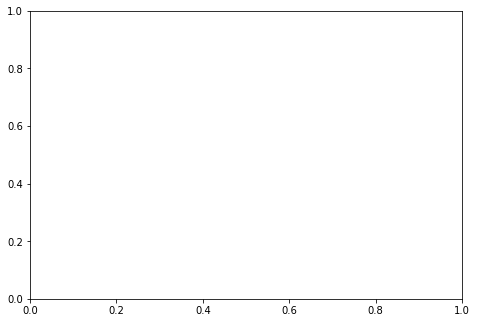

In [134]:
nx.draw(G)

In [56]:
pd.DataFrame(net).value_counts()

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [68]:
from kmodes.kmodes import KModes
km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(user[2:23])

TypeError: unorderable types: float() < str()

In [67]:
user[2:23]

,brand,GC,RAM,OS2,Screen,Touch
452075,AMD A8-7600 Radeon R7,NVIDIA GeForce GTX 950,7,Windows Pro 10.0,3840x2160,False
406667,Core(TM) i5-2430M,Intel(R) HD Graphics 3000,4,Windows Home 10.0,1366x768,False
371406,Core(TM) i5-4200M,Intel(R) HD Graphics 4600,4,Windows Pro 6.1,1366x768,False
269980,Core(TM) i5-4200H,Intel(R) HD Graphics 4600,8,Windows Home 10.0,1920x1080,False
183406,Core(TM) i5-4460,NVIDIA GeForce GTX 760,8,Windows Pro 10.0,1920x1080,False
77259,Core(TM) i5-7200U,Intel(R) HD Graphics 620,4,Windows Pro 10.0,1920x1080,False
609774,Core(TM) i7-6820HQ,Mirror,16,Windows Pro 10.0,1920x1080,False
503427,Core(TM) i5-7500,NVIDIA GeForce GTX 960,8,Windows Pro 10.0,1920x1080,False
574935,Core(TM) i3-3120M,NaN,6,Windows Pro 6.1,No Screen,No Screen
413535,Core(TM) i5-7200U,Intel(R) HD Graphics 620,4,Windows Home 10.0,1366x768,False


In [87]:
data = pd.read_csv('kmodes.csv')
pd.DataFrame(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 5 columns):
cpu        23 non-null int64
gpu        23 non-null int64
screen     23 non-null int64
display    23 non-null int64
card       23 non-null int64
dtypes: int64(5)
memory usage: 1000.0 bytes


In [97]:
km = KModes(n_clusters=3, init='Huang', n_init=10, verbose=1)
clusters = km.fit_predict(data)
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8, cost: 18.0
Run 1, iteration: 2/100, moves: 0, cost: 18.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 4, cost: 18.0
Run 2, iteration: 2/100, moves: 0, cost: 18.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 6, cost: 18.0
Run 3, iteration: 2/100, moves: 0, cost: 18.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 7, cost: 18.0
Run 4, iteration: 2/100, moves: 0, cost: 18.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 2, cost: 19.0
Run 5, iteration: 2/100, moves: 0, cost: 19.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 4, cost: 18.0
Run 6, iterati

In [85]:
### transform
#user.head()

,brand,GC,RAM,OS2,Screen,Touch
116092,Core(TM) i3-7100,Intel(R) HD Graphics 630,8,Windows Entreprise 10.0,1600x900,False
367991,Core(TM) i7-4770K,AMD(ATI) Radeon HD 7800,16,Windows Pro 6.3,"(1920x1080, 1920x1080)",False
452075,AMD A8-7600 Radeon R7,NVIDIA GeForce GTX 950,7,Windows Pro 10.0,3840x2160,False
406667,Core(TM) i5-2430M,Intel(R) HD Graphics 3000,4,Windows Home 10.0,1366x768,False
371406,Core(TM) i5-4200M,Intel(R) HD Graphics 4600,4,Windows Pro 6.1,1366x768,False


In [103]:
#user.brand.unique()
brand_dict={}
i=0
for brand in user.brand.unique():
    brand_dict[brand]=i
    i=i+1

user.brand=user.brand.apply(lambda x: brand_dict[x])

In [104]:
GC_dict={}
i=0
for gc in user.GC.unique():
    GC_dict[gc]=i
    i=i+1

user.GC=user.GC.apply(lambda x: GC_dict[x])

In [105]:
RAM_dict={}
i=0
for ram in user.RAM.unique():
    RAM_dict[ram]=i
    i=i+1

user.RAM=user.RAM.apply(lambda x: RAM_dict[x])

In [107]:
OS_dict={}
i=0
for os in user.OS2.unique():
    OS_dict[os]=i
    i=i+1

user.OS2=user.OS2.apply(lambda x: OS_dict[x])

In [109]:
Screen_dict={}
i=0
for s in user.Screen.unique():
    Screen_dict[s]=i
    i=i+1

user.Screen=user.Screen.apply(lambda x: Screen_dict[x])

In [112]:
def transformT(s):
    if s==False:
        return 0
    elif s==True:
        return 1
    else:
        return 3
    
user.Touch=user.Touch.apply(transformT)

In [113]:
user.head()

,brand,GC,RAM,OS2,Screen,Touch
116092,0,0,0,0,0,0
367991,1,1,1,1,1,0
452075,2,2,2,2,2,0
406667,3,3,3,3,3,0
371406,4,4,3,4,3,0


In [115]:
km = KModes(n_clusters=10, init='Huang', n_init=100, verbose=1)
clusters = km.fit_predict(user)
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2408, cost: 28570.0
Run 1, iteration: 2/100, moves: 830, cost: 28535.0
Run 1, iteration: 3/100, moves: 15, cost: 28535.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 3554, cost: 28100.0
Run 2, iteration: 2/100, moves: 407, cost: 28100.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3415, cost: 28418.0
Run 3, iteration: 2/100, moves: 876, cost: 28418.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 2194, cost: 29048.0
Run 4, iteration: 2/100, moves: 80, cost: 29048.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 3893, cost: 27971.0
Run 5, iteration: 2/100, moves: 477, cost: 27931.0
Run 5, iteration: 3/100, moves: 221,

Starting iterations...
Run 42, iteration: 1/100, moves: 2758, cost: 29049.0
Run 42, iteration: 2/100, moves: 1349, cost: 28794.0
Run 42, iteration: 3/100, moves: 241, cost: 28736.0
Run 42, iteration: 4/100, moves: 5, cost: 28736.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 43, iteration: 1/100, moves: 2051, cost: 29368.0
Run 43, iteration: 2/100, moves: 690, cost: 29368.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 44, iteration: 1/100, moves: 3462, cost: 28448.0
Run 44, iteration: 2/100, moves: 402, cost: 28299.0
Run 44, iteration: 3/100, moves: 8, cost: 28299.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 45, iteration: 1/100, moves: 1606, cost: 29308.0
Run 45, iteration: 2/100, moves: 37, cost: 29308.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 46, iteration: 1/100, moves: 2866, cost: 29054.0
Run 46, iteration: 2/100, moves:

Run 81, iteration: 1/100, moves: 3317, cost: 28561.0
Run 81, iteration: 2/100, moves: 19, cost: 28561.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 82, iteration: 1/100, moves: 3195, cost: 28506.0
Run 82, iteration: 2/100, moves: 433, cost: 27975.0
Run 82, iteration: 3/100, moves: 496, cost: 27975.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 83, iteration: 1/100, moves: 1861, cost: 28870.0
Run 83, iteration: 2/100, moves: 5, cost: 28870.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 84, iteration: 1/100, moves: 3566, cost: 27978.0
Run 84, iteration: 2/100, moves: 562, cost: 27978.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 85, iteration: 1/100, moves: 1458, cost: 29029.0
Run 85, iteration: 2/100, moves: 0, cost: 29029.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 86, iteration: 1/100, mo

In [121]:

print(list(brand_dict.keys())[list(brand_dict.values()).index(15)]) 

Core(TM) i7-6700


In [7]:
result.drop(['device_hw_proc','device_hw_video','device_hw_ram','device_os_name','device_os_version','device_hw_display'],axis=1).apply(lambda x: len(x.unique()),axis=0)

brand     71
GC        46
RAM       13
OS2       12
Screen    19
Touch      3
dtype: int64

In [37]:
result.drop(['device_hw_proc','device_hw_video','device_hw_ram','device_os_name','device_os_version','device_hw_display'],axis=1).apply(lambda x: len(x.unique()),axis=0).sum()

4423

In [64]:
ins,result1 = cleandata(user,filterCPU=0.3, filterGPU=2000000,filterRAM=0.24)

In [65]:
result1.drop(['device_hw_proc','device_hw_video','device_hw_ram','device_os_name','device_os_version','device_hw_display'],axis=1).apply(lambda x: len(x.unique()),axis=0).sum()

3810

In [63]:
result1.brand.value_counts()

Core(TM) i7-6700                                                                            23740
Core(TM) i7-6700HQ                                                                          21086
Core(TM) i7-4790                                                                            16911
Core(TM) i7-7700HQ                                                                          15542
Core(TM) i7-7500U                                                                           14611
Core(TM) i7-6500U                                                                           14386
Core(TM) i5-7200U                                                                           13045
Core(TM) i5-6200U                                                                           12527
Core(TM) i7-7700                                                                            11661
Core(TM) i7-3770                                                                            10744
Core(TM) i7-4770    

In [211]:
from sklearn.cluster import DBSCAN

In [215]:
dbs=DBSCAN(metric='precomputed')

In [222]:
dbs.fit(net)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='precomputed',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [219]:
labels = dbs.labels_

In [223]:
len(set(labels)) - (1 if -1 in labels else 0)

1